# MATH50003 Numerical Analysis: Problem Sheet 4

This problem sheet explores least squares, the QR decomposition including for
tridiagonal matrices,
and the PLU decompositions.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [4]:
using LinearAlgebra, Plots

## 1. Least squares and QR decompositions

**Problem 1.1** Find and plot the best least squares fit of ${1 \over 5x^2 + 1}$ by degree $n$
polynomials for $n = 0,\ldots,10$ at 1000 evenly spaced points between $0$ and $1$.

**SOLUTION**

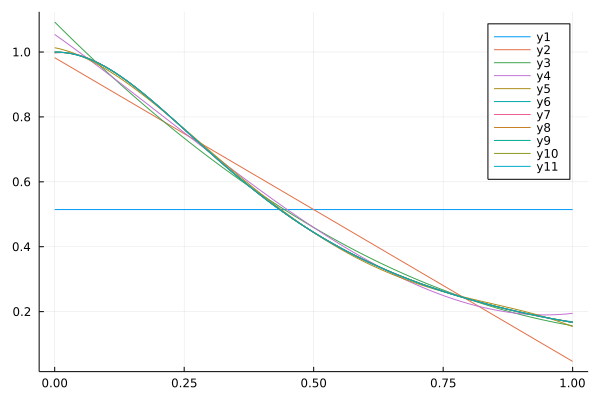

In [5]:
x = range(0, 1; length=1000)
pl = plot()
f = 1 ./ (5x.^2 .+ 1)
for n = 0:10
    A = x .^ (0:n)'
    c = A \ f
    plot!(x, A*c)
end
pl

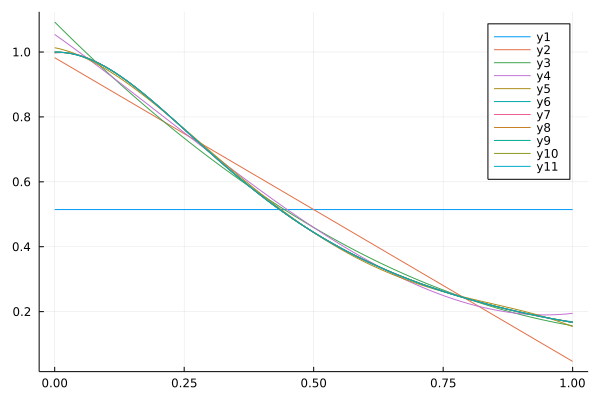

In [6]:
# Here is the same approach as above but this time explicitly using QR as discussed in the lecture notes:
x = range(0, 1; length=1000)
pl = plot()
f = 1 ./ (5x.^2 .+ 1)
for n = 0:10
    A = x .^ (0:n)'
    (Q,R)=qr(A)
    c = R \ Q[:,1:n+1]'*f
    plot!(x, A*c)
end
pl

**Problem 1.2⋆** Show that every matrix has a QR decomposition such that the diagonal of $R$ is non-negative.
Make sure to include the case of more columns than rows.

**SOLUTION**

Beginning with the square case, a square matrix $A=QR$ with square orthogonal $Q$ and square upper triangular $R$ can always be rewritten in the form $A=QD^{-1}DR$ where $D$ is a diagonal matrix with $sign(R[j,j])$ on the diagonal. As a result, $DR$ is an upper triangular matrix with positive diagonal. It remains to check that $QD^{-1}=-QD$ is still orthogonal - this is easy to check since $$-QD(-QD)^T = QDDQ^T = QQ^T = I.$$
Note we have made use of the fact that the inverse of a diagonal matrix is diagonal, that any diagonal matrix satisfies $D^{T} = D$ and that $DD=I$ since $\text{sign}(R[j,j])^2 = 1$.

The same argument works for the non-square cases as long as we take care to consider the appropriate dimensions and pad with the identity matrix. Note that $Q$ is always a square matrix in the $QR$ decomposition. Assume the $R$ factor has more columns $m$ than rows $n$. Then a square $n \times n$ diagonal matrix with its $n$ diagonal entries being $\text{sign}(R[j,j]), j=1..n$ works with the same argument as above.

Finally, assume that $R$ has less colums $m$ than rows $n$. In this case the square $n \times n$ diagonal matrix with its first $m$ diagonal entries being $\text{sign}(R[j,j]), j=1..m$ and any remaining diagonal entries being $1$ works with the same argument as above. 

Since the matrix $D$ is always square diagonal and orthogonal by construction, everything else for both of these cases is exactly as in the square case.

Here are some practical examples in Julia:

In [4]:
E = [-1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]
R = [-1 3; 0 2; 0 0; 0 0]

4×2 Matrix{Int64}:
 -1  3
  0  2
  0  0
  0  0

In [5]:
E*R

4×2 Matrix{Int64}:
 1  -3
 0   2
 0   0
 0   0

In [6]:
E = [-1 0 0 0; 0 1 0 0; 0 0 -1 0; 0 0 0 1]
R = [-1 3 7 8 2 1; 0 2 9 2 1 9; 0 0 -7 2 1 9; 0 0 0 7 5 2]

4×6 Matrix{Int64}:
 -1  3   7  8  2  1
  0  2   9  2  1  9
  0  0  -7  2  1  9
  0  0   0  7  5  2

In [7]:
E*R

4×6 Matrix{Int64}:
 1  -3  -7  -8  -2  -1
 0   2   9   2   1   9
 0   0   7  -2  -1  -9
 0   0   0   7   5   2

**Problem 1.3⋆** Show that the QR decomposition of a square invertible matrix is unique, 
provided that the diagonal of $R$ is positive.


**SOLUTION**

Assume there is a second decomposition also with positive diagonal
$$
A = QR = \tilde{Q} \tilde{R}
$$
Then we know 
$$
Q^⊤ \tilde{Q} = R \tilde{R}^{-1}
$$
Note $Q^⊤ \tilde{Q}$ is orthogonal, and $R \tilde{R}^{-1}$ has positive eigenvalues (the diagonal), hence all $m$ eigenvalues of
$Q^⊤ \tilde{Q}$ are 1. This means that $Q^⊤ \tilde{Q} = I$ and hence $\tilde{Q} = Q$, which then implies $\tilde{R} = R$.∎

## 2. Gram–Schmidt

**Problem 2.1⋆** The modified Gram–Schmidt algorithm is a slight variation of Gram–Schmidt where
instead of computing
$$
𝐯_j := 𝐚_j - \sum_{k=1}^{j-1} \underbrace{𝐪_k^\top 𝐚_j}_{r_{kj}} 𝐪_k
$$
we compute it step-by-step:
$$
\begin{align*}
𝐯_j^1 &:= 𝐚_j \\
𝐯_j^{k+1} &:= 𝐯_j^k - 𝐪_k^\top 𝐯_j^k 𝐪_k
\end{align*}
$$
Show that $𝐯_j^j = 𝐯_j$. 

**SOLUTION**

Recall that the column vectors of $Q$ are orthonormal i.e. $(𝐪_i,𝐪_j) = \delta_{ij}$.
Next observe that substituting from $𝐯^1_j$ for $𝐚_j$, for each $𝐯^i_j$ we get $i$ terms (note that the second term in the definition of $𝐯_j^{k+1}$ contributes only 1 term by orthonormality of $Q$, retrieving the contribution from $𝐯^{i-1}_j$ plus one.)
$$
𝐯^i_j := 𝐚_j - \sum_{k=1}^{i-2}{q_k^\top 𝐚_j} q_k - {q_{i-1}^\top 𝐚_j} q_{i-1}
$$

**Problem 2.2** Complete the following
function implementing the modified Gram–Schmidt algorithm:

In [8]:
function modifiedgramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        # TODO: Implement the Modified Gram–Schmidt algorthm
    end
    Q,R
end

modifiedgramschmidt (generic function with 1 method)

**SOLUTION**

In [9]:
function modifiedgramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        v = A[:,j]
        for k = 1:j-1
            R[k,j] = Q[:,k]'*v
            v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        end
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end

A = randn(300,300)
Q,R = modifiedgramschmidt(A)
A-Q*R

300×300 Matrix{Float64}:
 0.0           0.0           0.0          …  -8.88178e-16   1.11022e-15
 0.0           2.22045e-16   0.0              4.44089e-16  -5.55112e-17
 0.0           0.0           0.0              5.55112e-17   2.22045e-16
 2.22045e-16   2.22045e-16   0.0             -1.38778e-16   1.66533e-16
 0.0          -4.44089e-16   0.0             -2.22045e-16   4.44089e-16
 0.0           0.0          -1.11022e-16  …  -2.22045e-16  -8.88178e-16
 0.0           0.0           0.0              2.22045e-16   2.498e-16
 0.0           0.0           1.11022e-16     -8.88178e-16  -7.77156e-16
 0.0          -5.55112e-17   0.0              1.38778e-16   4.44089e-16
 0.0           0.0           0.0              8.88178e-16   2.22045e-16
 0.0           0.0           2.22045e-16  …   1.33227e-15  -7.21645e-16
 0.0           0.0           0.0              0.0          -4.44089e-16
 1.38778e-17   0.0          -2.77556e-17      5.55112e-17   7.77156e-16
 ⋮                                       

**Problem 2.3** Compare the orthogonality of `Q` between `gramschmidt` and `modifiedgramschmidt`
when applied to a `300 × 300` random matrix.

**SOLUTION**

For reference, here is the gramschmidt algorithm from the lecture notes:

In [10]:
function gramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end

# Now compare MGS with GS:

A = randn(300,300)
Q,R = gramschmidt(A)
Qm,Rm = modifiedgramschmidt(A)

maximum(abs.(Q*Q')-I)

1.629946178027808e-14

In [11]:
maximum(abs.(Qm*Qm')-I)

1.880440247958859e-15

## 3. Householder reflections

**Problem 3.1**
Complete the definition of `Reflections` which supports a sequence of reflections,
that is, 
$$
Q = Q_{𝐯_1} \cdots Q_{𝐯_n}
$$
where the vectors are stored as a matrix `V` whose $j$-th column is $𝐯_j$, and
$$
Q_{𝐯_j} = I - 2 𝐯_j 𝐯_j^\top.
$$

In [12]:
struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

import Base: *, size, getindex

size(Q::Reflections) = (size(Q.v,1), size(Q.v,1))


function *(Q::Reflections, x::AbstractVector)
    # TODO: Apply Q in O(mn) operations
end

function getindex(Q::Reflections, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(mn) operations (hint: use *)
end

getindex (generic function with 325 methods)

**SOLUTION**

In [13]:
struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

import Base: *, size, getindex

size(Q::Reflections) = (size(Q.V,1),size(Q.V,1))

function *(Q::Reflections, x::AbstractVector)
    M = x-2*Q.V[1:end,end]*Q.V[1:end,end]'*x
    for j = size(Q.V,2)-1:-1:1
        M = M-2*Q.V[1:end,j]*Q.V[1:end,j]'*M
    end
    return M
end

function getindex(Q::Reflections, k::Int, j::Int)
    T = eltype(Q.V)
    ej = zeros(T,size(Q,1))
    ej[j] = one(T)
    return (Q*ej)[k]
end

getindex (generic function with 325 methods)

**Problem 3.2** Complete the following function that implements
 Householder QR using only $O(mn^2)$ operations:

In [14]:
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Reflections(Matrix(1.0I, m, n))
    for j = 1:n
        # TODO: populate Q and R using O(m*(n-j)) operations
    end
    Q,R
end

householderqr (generic function with 1 method)

**SOLUTION**

In [15]:
function householderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Reflections(Matrix(0.0I, m, n))
    for j = 1:min(n,m)
        y = copy(R[j:end,j])
        y[1] += ((y[1] ≥ 0) ? 1 : -1)*norm(y)
        w = y/norm(y)
        Q.V[j:end,j] = w
        R[j:end,:] = R[j:end,:]-2*w*(w'*R[j:end,:])
    end
    return Q,R
end

# Some testing:
A = randn(4,6)
Q,R = householderqr(A)
Q*R-A

4×6 Matrix{Float64}:
 -1.11022e-15   0.0          -4.44089e-16  …  -1.77636e-15  -2.22045e-16
  2.22045e-16  -4.44089e-16  -5.55112e-17      4.44089e-16   2.77556e-17
 -5.55112e-17   0.0          -2.22045e-16     -2.22045e-16  -5.55112e-17
  1.11022e-16   0.0          -1.11022e-16      1.11022e-16   3.03577e-17

In [16]:
# Here's a performance comparison with what we saw in the lecture notes:
function householderreflection(x)
    y = copy(x)
    # we cannot use sign(x[1]) in case x[1] == 0
    y[1] += (x[1] ≥ 0 ? 1 : -1)*norm(x) 
    w = y/norm(y)
    I - 2*w*w'
end
function lecturehouseholderqr(A)
    m,n = size(A)
    R = copy(A)
    Q = Matrix(1.0I, m, m)
    for j = 1:n
        Qⱼ = householderreflection(R[j:end,j])
        R[j:end,:] = Qⱼ*R[j:end,:]
        Q[:,j:end] = Q[:,j:end]*Qⱼ
    end
    Q,R
end

using BenchmarkTools

for j = 1:5
    A = randn(j*100,j*100)
    @btime lecturehouseholderqr(A);
end

  7.475 ms (1335 allocations: 20.91 MiB)
  57.984 ms (2875 allocations: 164.88 MiB)
  211.692 ms (4391 allocations: 554.01 MiB)
  667.755 ms (5895 allocations: 1.28 GiB)
  1.205 s (7399 allocations: 2.50 GiB)


In [17]:
for j = 1:5
    A = randn(j*100,j*100)
    @btime householderqr(A);
end

  2.992 ms (1125 allocations: 15.82 MiB)
  26.293 ms (2365 allocations: 124.19 MiB)
  92.690 ms (3581 allocations: 416.67 MiB)
  239.469 ms (4785 allocations: 984.77 MiB)
  460.147 ms (5989 allocations: 1.88 GiB)


## 4. Banded QR with Given's rotations

**Problem 4.1⋆**  Describe an algorithm for computing the QR decomposition
of a tridiagonal matrix using rotations instead of reflections to upper-triangularise
column-by-column.

**SOLUTION**

Let $A$ be a tridiagonal matrix:

$$
A = \left[\begin{matrix} 
a_{11} & a_{12} & 0 & \cdots  &0\\
a_{21} & a_{22} & a_{23} & \ddots  &\vdots\\
0      & a_{32} & a_{33} & \ddots  &0\\
       & 0      & \ddots & \ddots  &a_{n-1,n}\\
       &        & 0      & a_{n,n-1}  & a_{nn} 
\end{matrix}\right] = 
\left[ \begin{matrix}
\mathbf{a}_1 & \mathbf{a}_2 &\cdots & \mathbf{a}_n
\end{matrix}\right],
$$
where each $\mathbf{a}_j \in \mathbb{R}^n$ and $[\mathbf{a}_j]_k = 0$ for $|j-k| > 1$.

Recall that,
$$
\frac{1}{\sqrt{a^2 + b^2}} \left[\begin{matrix}
a & b \\
-b & a
\end{matrix}\right] \left[\begin{matrix}
a \\ b
\end{matrix}\right] = \left[\begin{matrix}
\sqrt{a^2 + b^2} \\ 0
\end{matrix}\right],
$$
and that,
$$
\frac{1}{\sqrt{a^2 + b^2}} \left[\begin{matrix}
a & b \\
-b & a
\end{matrix}\right] = \left[\begin{matrix}
\cos \theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{matrix}\right],
$$
is a rotation matrix where $\theta = -\arctan(b/a)$. With this in mind, consider multiplying $A$ from the left by,
$$
Q_1 = \left[\begin{matrix}
\frac{a_{11}}{r_{11}} & \frac{a_{21}}{r_{11}} \\
-\frac{a_{21}}{r_{11}} & \frac{a_{11}}{r_{11}} \\
&&1\\
&&&\ddots\\
&&&&1
\end{matrix}\right],
$$
where $r_{11} = \sqrt{a_{11}^2 + a_{21}^2}$. This rotates dimensions 1 and 2 through angle $\theta=-\arctan(a_{21}/a_{11})$. We have,
$$
Q_1 \mathbf{a}_1 = \left[\begin{matrix}
r_{11} \\0 \\ \vdots \\ 0
\end{matrix}\right],\hspace{10mm}
Q_1 \mathbf{a}_2 = \left[\begin{matrix}
r_{12} := \frac{1}{r_{11}}(a_{11}a_{12} + a_{21}a_{22}) \\
t_1    := \frac{1}{r_{11}}(a_{11}a_{22} - a_{21}a_{12}) \\
a_{32} \\
0 \\
\vdots \\ 0
\end{matrix}\right],\hspace{10mm}
Q_1 \mathbf{a}_3 = \left[\begin{matrix}
r_{13} := \frac{1}{r_{11}}a_{21}a_{23} \\
s_1    := \frac{1}{r_{11}}a_{11}a_{23} \\
a_{33} \\
a_{43} \\
0 \\
\vdots \\ 0
\end{matrix}\right],\hspace{10mm}
Q_1 \mathbf{a}_k = \mathbf{a}_k \textrm{ for } k > 3.
$$
Then we take,
$$
Q_2 = \left[ \begin{matrix}
1 \\
& \frac{t_1}{r_{22}} & \frac{a_{32}}{r_{22}} \\
& -\frac{a_{32}}{r_{22}} & \frac{t_1}{r_{22}} \\
&&&1 \\
&&&&\ddots\\
&&&&&1
\end{matrix}\right],
$$
where $r_{22} = \sqrt{t_1^2 + a_{32}^2}$, a matrix which rotates dimensions 2 and 3 through angle $\theta_2 = -\arctan(a_{32}/t_1)$. Then,
$$
Q_2 Q_1 \mathbf{a}_{1} = Q_1\mathbf{a}_1 = \left[\begin{matrix}
r_{11} \\0 \\ \vdots \\ 0
\end{matrix}\right],\hspace{10mm}
Q_2 Q_1 \mathbf{a}_{2} = Q_2\left[\begin{matrix}
r_{12} \\
t_1    \\
a_{32} \\
0 \\
\vdots \\ 0
\end{matrix}\right] = \left[\begin{matrix}
r_{12} \\
r_{22} \\
0 \\
0 \\
\vdots \\
0
\end{matrix}\right],\hspace{10mm}
Q_2Q_1\mathbf{a}_3 = Q_2 \left[\begin{matrix}
r_{13} \\
s_1    \\
a_{33} \\
a_{43} \\
0 \\
\vdots \\ 0
\end{matrix}\right]
=\left[\begin{matrix}
r_{13} \\
r_{23} := \frac{1}{r_{22}}(t_1s_1 + a_{32}a_{33})  \\
t_2 := \frac{1}{r_{22}}(t_1a_{33} - a_{32}s_1) \\
a_{43} \\
0 \\
\vdots \\ 0
\end{matrix}\right]
$$

$$
Q_2Q_1\mathbf{a}_4 = Q_2\left[\begin{matrix}
0 \\
0 \\
a_{34} \\
a_{44} \\
a_{54} \\
0 \\
\vdots \\
0
\end{matrix}\right] = \left[\begin{matrix}
0 \\
r_{24} := \frac{1}{r_{22}}a_{32}a_{34} \\
s_2 := \frac{1}{r_{22}} t_1 a_{34} \\
a_{44} \\
a_{54} \\
0 \\
\vdots \\
0
\end{matrix}\right], \hspace{10mm}
Q_2Q_1 \mathbf{a}_k = \mathbf{a}_k \textrm{ for } k > 4.
$$

Now, for $j=3\rightarrow n-1$ we take,
$$
Q_j := \left[\begin{matrix}
\mathbf{I}_{j-1} \\
& \frac{t_{j-1}}{r_{jj}} & \frac{a_{j+1, j}}{r_{jj}} \\
& \frac{a_{j+1, j}}{r_{jj}} & \frac{t_{j-1}}{r_{jj}} \\
&&& \mathbf{I}_{n-j-1}
\end{matrix}\right],
$$
where $r_{jj} := \sqrt{t_{j-1}^2 + a_{j+1, j}^2}$.

This gives,
$$
Q_j \dots Q_1 \mathbf{a}_k =  \left[\begin{matrix}
\mathbf{0}_{k-3} \\
r_{k-2,k} \\
r_{k-1, k} \\
r_{k,k} \\
\mathbf{0}_{n-k}
\end{matrix}\right],
$$
for $k \leq j$, 
and,
$$
Q_j \dots Q_1 \mathbf{a}_{j+1} = \left[\begin{matrix}
\mathbf{0} \\
r_{j-1,j+1} \\
r_{j,j+1} := \frac{1}{r_{jj}}(t_{j-1}s_{j-1} + a_{j+1,j}a_{j+1,j+1}) \\
t_j := \frac{1}{r_{jj}}(t_{j-1}a_{j+1,j+1} - s_{j-1}a_{j+1,j})\\
a_{j+2,j+1} \\
0 \\
\vdots \\ 0
\end{matrix}\right],\hspace{10mm}
Q_j \dots Q_1 \mathbf{a}_{j+2} = \left[\begin{matrix}
\mathbf{0} \\
r_{j,j+2} := \frac{1}{r_{jj}}a_{j+1,j}a_{j+1,j+2} \\
s_j := \frac{1}{r_{jj}}t_{j-1} a_{j+1,j+2} \\
a_{j+2,j+2} \\
0 \\
\vdots \\ 
0
\end{matrix}\right].
$$
Finally we define, $r_{nn} = \frac{1}{r_{n-1,n-1}}(t_{n-2}a_{n,n} - a_{n, n-1}s_{n-2})$, to obtain,

$$
Q_{n-1}\dots Q_1 A = \left[\begin{matrix}
r_{11} & r_{12} & r_{13} & 0      & \dots & 0\\
0      & r_{22} & r_{23} & r_{24} &       & 0\\
       & \ddots      & \ddots & \ddots & \ddots  & \vdots\\
       &             &    0    &  r_{n-2,n-2} & r_{n-2, n-1}     & r_{n-2,n}\\
       &             &        &    0    &     r_{n-1,n-1}    & r_{n-1,n}\\
       &             &        &        &     0    & r_{n,n}\\
\end{matrix}\right] =: R
$$

so that $A = QR$, for $Q = Q_1^{-1}\dots Q_{n-1}^{-1}$, where each matrix $Q_j$ rotates the coordinates $(j,j+1)$ through the angle $\theta_j = -\arctan(a_{j+1, j}/t_{j-1})$, and thus each matrix $Q_j^{-1}$ rotates the coordinates $(j, j+1)$ through the angle $\arctan(a_{j+1, j}/t_{j-1})$. This will be important for Problem 4.3.


**Problem 4.2** Implement `Rotations` which represents an orthogonal matrix `Q` that is a product
 of rotations of angle `θ[k]`, each acting on the entries `k:k+1`.

In [18]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T}
end

import Base: *, size, getindex

size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)


function *(Q::Rotations, x::AbstractVector)
    # TODO: Apply Q in O(n) operations
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)
end

getindex (generic function with 333 methods)

**SOLUTION**

Implement Rotations which represents an orthogonal matrix ```Q``` that is a product of rotations of angle ```θ[k]```, each acting on the entries ```k:k+1```.

Note that this can be interpreted in two ways. We can either:

1. Rotate coordinates ```1:2``` through angle ```θ[1]```, then rotate coordinates ```2:3``` through angle ```θ[2]```, $\dots$, then rotate coordinates ```n-1:n``` through angle ```θ[n-1]```. Or we could,
2. Rotate coordinates ```n-1:n``` through angle ```θ[n-1]```, then rotate coordinates ```n-2:n-1``` through angle ```θ[n-2]```, $\dots$, then rotate coordinates ```1:2``` through angle ```θ[1]```.

Observe that the the form of the matrix $Q$ above would work best with the second implementation, so that is the one we choose to implement below (though technically both answers are correct).

In [19]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T}
end

import Base: *, size, getindex

size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)

function *(Q::Rotations, x::AbstractVector)
    # TODO: Apply Q in O(n) operations
    y = convert(Vector{AbstractFloat},x)
    θ = Q.θ
    #Does Q1....Qn x
    for k=length(Q.θ):-1:1
        #below has 4 ops to make the matrix and 12 to do the matrix-vector multiplication,
        #total operations will be 48n = O(n)
       y[k:(k+1)] = [cos(θ[k]) (-sin(θ[k])); sin(θ[k]) cos(θ[k])]*y[k:(k+1)]
    end
    y
end

function getindex(Q::Rotations, k::Int, j::Int)
    #recall that A_kj = e_k'*A*e_j for any matrix A
    #so if we use * above, this will take O(n) operations
    n = size(Q)[1]
    ej = zeros(n)
    ej[j] = 1
    #note, must be careful to ensure that ej is a VECTOR
    #not a MATRIX, otherwise * above will not be used
    Qj = Q*ej
    Qj[k]
end

getindex (generic function with 333 methods)

For example:

In [20]:
θ1 = [0.5, 1, 1.5, 2]
R = Rotations(θ1)

5×5 Rotations{Float64}:
 0.877583  -0.259035   0.028537    0.167463    0.365912
 0.479426   0.47416   -0.0522366  -0.306538   -0.669798
 0.0        0.841471   0.0382195   0.224282    0.490065
 0.0        0.0        0.997495   -0.0294371  -0.0643212
 0.0        0.0        0.0         0.909297   -0.416147

**Problem 4.3** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition that only takes $O(n)$ operations:

In [21]:
function bandedqr(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n-1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n-1), zeros(n-2))
    for j = 1:n-1
        # TODO: populate Q and R
    end
    Q,R
end

bandedqr (generic function with 1 method)

**SOLUTION**

First we make sure that the ```UpperTridiagonal``` class is defined, this will be where we store our values $r_{i,j}$:

In [22]:
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
    if j - k == 0
        d[j]
    elseif j - k == 1
        du[k]
    elseif j - k == 2
        du2[k]
    else
        0
    end
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2
        error("Cannot modify off-band")
    end

    # TODO: modify d,du,du2 so that U[k,j] == v
    if j - k == 0
        d[k] = v
    elseif j - k == 1
        du[k] = v
    elseif j - k == 2
        du2[k] = v
    else
        error("Cannot modify off-band")
    end
    U = UpperTridiagonal(d,du,du2)

    U # by convention we return the matrix
end

setindex! (generic function with 1 method)

Now we implement the algorithm described above. Note that at each stage it is sufficient to compute and store the following six quantities:
\begin{align}
\theta_j &= \arctan(a_{j+1,j}/t_{j-1})\\
r_{jj} &= \sqrt{t_{j-1}^2 + a_{j+1,j}^2}, \\
r_{j,j+1} &= \frac{1}{r_{jj}}(t_{j-1}s_{j-1} + a_{j+1,j}a_{j+1,j+1}) \\
r_{j,j+2} &= \frac{1}{r_{jj}}a_{j+1,j}a_{j+1,j+2} \\
t_{j} &= \frac{1}{r_{jj}}(t_{j-1}a_{j+1,j+1}) - s_{j-1}a_{j+1, j} \\
s_j &= \frac{1}{r_{jj}}t_{j-1}a_{j+1,j+2}
\end{align}
Note that we store $\arctan(a_{j+1,j}/t_{j-1})$ as we are interested in $Q = Q_1^{-1}\dots Q_n^{-1}$, where each $Q_j^{-1}$ rotates the coordinates ```j:j+1``` through angle $\arctan(a_{j+1,j}/t_{j-1})$. We don't have to store any values for $Q$ as our implementation of ```Rotations``` above will construct $Q$ from the list of angles that we store.

In [23]:
using LinearAlgebra
function bandedqr(A::Tridiagonal)
    n = size(A,1)
    Q = Rotations(zeros(n-1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n-1), zeros(n-2))
    t = zeros(n-1)
    s = zeros(n-1)
    
    #we will do the first iteration outside of the loop as t and s have special values here
    #find the first angle, note we take the negative as we want the inverse of Q where QA = R
    Q.θ[1] = atan(A[2,1], A[1,1])
    
    #update values for R
    #R_11
    v = sqrt(A[1,1]^2 + A[2,1]^2)
    setindex!(R, v, 1, 1)
    #R_12
    v = 1/R[1,1] * (A[1,1]*A[1,2] + A[2,1]*A[2,2])
    setindex!(R, v, 1, 2)
    #R_13
    v = A[2,1]*A[2,3]/R[1,1]
    setindex!(R, v, 1, 3)
    
    #create initial storage values
    t[1] = (-A[2,1]*A[1,2] + A[1,1]*A[2,2])/R[1,1]
    s[1] = A[1,1]*A[2,3]/R[1,1]
    
    if n==2
       Q, R 
    end
    
    for j = 2:(n-1)
        Q.θ[j] = atan(A[j+1,j],t[j-1])
        
        v = sqrt(A[j+1,j]^2 + t[j-1]^2)
        setindex!(R, v, j, j)
        
        v=1/R[j,j]*(t[j-1]*s[j-1] + A[j+1,j]*A[j+1,j+1])
        setindex!(R, v, j, j+1)
        
        #only compute this if j+2 <= n
        #equivalently.        j < n-1
        if j < n-1
            v=1/R[j,j]*A[j+1,j]*A[j+1, j+2]
            setindex!(R, v, j, j+2)
        end
        
        t[j] = 1/R[j,j]*(-A[j+1,j]*s[j-1] + t[j-1]*A[j+1, j+1])
        
        #only compute this if j < n-1
        if j < n-1
            s[j] = 1/R[j,j]*t[j-1]*A[j+1, j+2]
        end
    end
    v = (-A[n, n-1]*s[n-2] + t[n-2]*A[n,n])/R[n-1,n-1]
    setindex!(R, v, n, n)
    #now we just need to invert Q
    
    Q,R
end

bandedqr (generic function with 1 method)

We can check an example:

In [24]:
A = Tridiagonal([1, 2, 3, 4], [1, 2, 3, 4, 5], [1, 2, 3, 4])

5×5 Tridiagonal{Int64, Vector{Int64}}:
 1  1  ⋅  ⋅  ⋅
 1  2  2  ⋅  ⋅
 ⋅  2  3  3  ⋅
 ⋅  ⋅  3  4  4
 ⋅  ⋅  ⋅  4  5

In [25]:
Q, R = bandedqr(A)

([0.7071067811865476 -0.23570226039551576 … 0.2238258009335639 0.6236396404016914; 0.7071067811865475 0.2357022603955158 … -0.22382580093356394 -0.6236396404016915; … ; 0.0 0.0 … 0.037304300155594036 0.10393994006694873; 0.0 0.0 … 0.94121618854114 -0.3378048052175831], [1.4142135623730951 2.1213203435596424 … 0 0; 0 2.1213203435596424 … 2.8284271247461903 0; … ; 0 0 … 4.249820656187282 4.855298143328075; 0 0 … 0 -1.27326426582012])

In [26]:
Q*R - A

5×5 Matrix{Float64}:
 2.22045e-16   2.22045e-16  -5.55112e-17   4.44089e-16   2.22045e-16
 0.0          -4.44089e-16   0.0          -3.33067e-16  -1.11022e-16
 0.0          -2.22045e-16   0.0           4.44089e-16   5.55112e-17
 0.0           0.0           0.0           0.0           8.88178e-16
 0.0           0.0           0.0           0.0          -8.88178e-16

**Problem 4.4⋆** Could one redesign the above to only use IEEE operatations (addition, multiplication, square-roots, 
avoiding calls `atan`, `cos`, and `sin`)?
Would it have been possible to implement this algorithm using reflections?
If so, what would be the structure of a matrix whose columns are the vectors of reflections?

**SOLUTION**

Yes, one could avoid using ```atan```, ```cos```, and ```sin```. At each stage of the algorithm, we only use ```atan``` to compute ```θ[i]``` which we then use to compute $Q_i^{-1}$ and thus $Q$ at the end. Instead, one could simply compute $Q_i^{-1}$ directly from $t_{i-1}$ and $a_{i+1, i}$ and save it at each stage. An efficient implementation of $Q_1^{-1}\dots Q_n^{-1}$ would then compute $Q$ at the end.
One could implement this using Householder Reflections as well. Interpreting the 'vectors of reflections' to mean the vectors which define each Householder reflection (padded with 0s at the front so that they are the same dimension and fit into a matrix), the matrix with these columns would be a lower bidiagonal matrix with bandwidths $(l, u) = (1, 0)$.

## 5. PLU decomposition

**Problem 5.1⋆** Compute the PLU decompositions for the following matrices:
$$
\begin{bmatrix}
0 & 2 & 1 \\
2 & 6 & 1 \\
1 & 1 & 4
\end{bmatrix},
\begin{bmatrix}
1 & 2 & -1 & 0 \\
2 & 4 & -2 & 1 \\
-3 & -5 & 6 & 1 \\
-1 & 2 & 8 & -2
\end{bmatrix}
$$

**SOLUTION**
**Part 1**
Compute the PLU decomposition of,
$$ \left[ \begin{matrix}
0 & 2 & 1 \\ 
2 & 6 & 1 \\ 
1 & 1 & 4
\end{matrix} \right]$$
We begin by permuting the first and second row as |2| > |0|, hence,
$$P_1 =  \left[ \begin{matrix}
0 & 1 & 0 \\ 
1 & 0 & 0 \\ 
0 & 0 & 1
\end{matrix} \right], \hspace{10mm}
P_1A =  \left[ \begin{matrix}
2 & 6 & 1 \\ 
0 & 2 & 1 \\ 
1 & 1 & 4
\end{matrix} \right]
$$
We then choose,
$$
L_1 = \left[ \begin{matrix}
1 & 0 & 0 \\ 
0 & 1 & 0 \\ 
-\frac{1}{2} & 0 & 1
\end{matrix} \right], \hspace{10mm}
L_1P_1A =  \left[ \begin{matrix}
2 & 6 & 1 \\ 
0 & 2 & 1 \\ 
0 & -2 & \frac{7}{2}
\end{matrix} \right]
$$
There is no need to permute at this stage, so $P_2 = I_3$, the $3-$dimensional identity. Then we can choose,
$$
L_2 = \left[ \begin{matrix}
1 & 0 & 0 \\ 
0 & 1 & 0 \\ 
0 & 1 & 1
\end{matrix} \right], \hspace{10mm}
L_2 P_2 L_1 P_1 A =  \left[ \begin{matrix}
2 & 6 & 1 \\ 
0 & 2 & 1 \\ 
0 & 0 & 9/2
\end{matrix} \right] =: U
$$
Since $P_2 = I_3$, this reduces to $L_2L_1P_1A = U \Rightarrow A = P_1^{-1}L_1^{-1}L_2^{-1}U$. Since $P_1$ simply permutes two rows, it is its own inverse, and $L_1^{-1}L_2^{-1}$ is simply,
$$ 
L := L_1^{-1}L_2^{-1} = 
\left[ \begin{matrix}
1 & 0 & 0 \\ 
0 & 1 & 0 \\ 
\frac{1}{2} & -1 & 1
\end{matrix} \right]
$$
Hence, we have $A = PLU$, where,
$$
P = P_1^{-1}= \left[ \begin{matrix}
0 & 1 & 0 \\ 
1 & 0 & 0 \\ 
0 & 0 & 1
\end{matrix} \right], \hspace{10mm}
L = \left[ \begin{matrix}
1 & 0 & 0 \\ 
0 & 1 & 0 \\ 
\frac{1}{2} & -1 & 1
\end{matrix} \right], \hspace{10mm}
U=\left[ \begin{matrix}
2 & 6 & 1 \\ 
0 & 2 & 1 \\ 
0 & 0 & 9/2
\end{matrix} \right]
$$
We can quickly check:

In [27]:
P = [0 1 0; 1 0 0; 0 0 1]
L = [1 0 0; 0 1 0; 1/2 -1 1]
U = [2 6 1; 0 2 1; 0 0 9/2]

P*L*U

3×3 Matrix{Float64}:
 0.0  2.0  1.0
 2.0  6.0  1.0
 1.0  1.0  4.0

**Part 2**

Find the $PLU$ decomposition of,
$$
A = \left[\begin{matrix}
1 & 2 & -1 & 0 \\
2 & 4 & -2 & 1 \\
-3 & -5 & 6 & 1 \\
-1 & 2 & 8 & -2
\end{matrix}
\right]
$$
We see that we must start with the permutation,
$$
P_1 :=\left[\begin{matrix}
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{matrix}
\right], \hspace{10mm}
P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
2 & 4 & -2 & 1 \\
1 & 2 & -1 & 0 \\
-1 & 2 & 8 & -2
\end{matrix}
\right]
$$
We then choose $L_1$,
$$
L_1 := \left[\begin{matrix}
1 & 0 & 0 & 0 \\
\frac{2}{3} & 1 & 0 & 0 \\
\frac{1}{3} & 0 & 1 & 0 \\
-\frac{1}{3} & 0 & 0 & 1
\end{matrix}
\right], \hspace{10mm}
L_1P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{2}{3} & 2 & \frac{5}{3} \\
0 & \frac{1}{3} & 1 & \frac{1}{3} \\
0 & \frac{11}{3} & 6 & -\frac{7}{3}
\end{matrix}
\right]
$$
We then choose $P_2$,
$$
P_2 :=\left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{matrix}
\right], \hspace{10mm}
P_2L_1P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{11}{3} & 6 & -\frac{7}{3} \\
0 & \frac{1}{3} & 1 & \frac{1}{3} \\
0 & \frac{2}{3} & 2 & \frac{5}{3} 
\end{matrix}
\right]
$$
We then choose $L_2$,
$$
L_2 := \left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & -\frac{1}{11} & 1 & 0 \\
0 & -\frac{2}{11} & 0 & 1
\end{matrix}
\right], \hspace{10mm}
L_2P_2L_1P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{11}{3} & 6 & -\frac{7}{3} \\
0 & 0 & \frac{5}{11} & \frac{6}{11} \\
0 & 0 & \frac{10}{11} & \frac{23}{11} 
\end{matrix}
\right]
$$
We then choose $P_3$ to swap the third and fourth rows,
$$
P_3 :=\left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{matrix}
\right], \hspace{10mm}
P_3L_2P_2L_1P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{11}{3} & 6 & -\frac{7}{3} \\
0 & 0 & \frac{10}{11} & \frac{23}{11} \\
0 & 0 & \frac{5}{11} & \frac{6}{11} 
\end{matrix}
\right]
$$
We complete the triangularisation by choosing $L_3$,
$$
L_3 := \left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & -\frac{1}{2} & 1
\end{matrix}
\right], \hspace{10mm}
L_3P_3L_2P_2L_1P_1A = \left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{11}{3} & 6 & -\frac{7}{3} \\
0 & 0 & \frac{10}{11} & \frac{23}{11} \\
0 & 0 & 0 & -\frac{1}{2}
\end{matrix}
\right]
$$
We now consider,
$$L_3P_3L_2P_2L_1P_1 = L_3\tilde{L_2}\tilde{L_1}P_3P_2P_1,$$
where $\tilde{L_1}$ and $\tilde{L_1}$ satisfy,

\begin{align}
P_3P_2L_1 &= \tilde{L_1}P_3P_2 \\
P_3L_2 &= \tilde{L_2}P_3
\end{align}

These can be computed via,
\begin{align}
\tilde{L_1} &= P_3P_2L_1P_2^{-1}P_3^{-1} \\
\tilde{L_2} &= P_3L_2P_3^{-1}
\end{align}
to obtain,
\begin{align}
\tilde{L_1} &= \left[\begin{matrix}
1 & 0 & 0 & 0 \\
-\frac{1}{3} & 1 & 0 & 0 \\
\frac{2}{3} & 0 & 1 & 0 \\
\frac{1}{3} & 0 & 0 & 1 \\
\end{matrix}
\right] \\
\tilde{L_2} &= \left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & -\frac{2}{11} & 1 & 0 \\
0 & -\frac{1}{11} & 0 & 1 \\
\end{matrix}
\right]
\end{align}

This gives us,
$$L^{-1} = L_3 \tilde{L_2} \tilde{L_1} = \left[\begin{matrix}
1 & 0 & 0 & 0 \\
-\frac{1}{3} & 1 & 0 & 0 \\
\frac{2}{3} & -\frac{2}{11} & 1 & 0 \\
\frac{1}{3} & -\frac{1}{11} & -\frac{1}{2} & 1
\end{matrix}
\right],$$
from which it is clear that,
$$L =  \left[\begin{matrix}
1 & 0 & 0 & 0 \\
\frac{1}{3} & 1 & 0 & 0 \\
-\frac{2}{3} & \frac{2}{11} & 1 & 0 \\
-\frac{1}{3} & \frac{1}{11} & \frac{1}{2} & 1
\end{matrix}
\right]$$

Finally, we have that, 
$$
P = P_1^{-1} P_2^{-1} P_3^{-1} = \left[ \begin{matrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{matrix}\right],
$$
so that $A = PLU,$ with,
$$
P = P_1^{-1} P_2^{-1} P_3^{-1} = \left[ \begin{matrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{matrix}\right], \hspace{10mm}
L =  \left[\begin{matrix}
1 & 0 & 0 & 0 \\
\frac{1}{3} & 1 & 0 & 0 \\
-\frac{2}{3} & \frac{2}{11} & 1 & 0 \\
-\frac{1}{3} & \frac{1}{11} & \frac{1}{2} & 1
\end{matrix}
\right], \hspace{10mm}
U=\left[\begin{matrix}
-3 & -5 & 6 & 1 \\
0 & \frac{11}{3} & 6 & -\frac{7}{3} \\
0 & 0 & \frac{10}{11} & \frac{23}{11} \\
0 & 0 & 0 & -\frac{1}{2}
\end{matrix}
\right]
$$
To check:

In [28]:
P=[0 0 0 1;0 0 1 0;1 0 0 0;0 1 0 0]
L=[1 0 0 0;1/3 1 0 0; -2/3 2/11 1 0; -1/3 1/11 1/2 1]
U=[-3 -5 6 1;0 11/3 6 -7/3;0 0 10/11 23/11;0 0 0 -1/2]
P*L*U

4×4 Matrix{Float64}:
  1.0   2.0  -1.0   0.0
  2.0   4.0  -2.0   1.0
 -3.0  -5.0   6.0   1.0
 -1.0   2.0   8.0  -2.0